# 4.5 - Transfer learning

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [2]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
import pickle, bz2
%matplotlib inline
%load_ext tensorboard

## Observe AlexNet filters for the first two convolutional layers

Pretrained Network: [https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/](https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/)

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Source images: [Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/) [ImageNet](http://www.image-net.org)

Local file with weights from first two layers only



In [5]:
!ls -lash local/data/alexnet_conv1_conv2.pklz

1,4M -rw-r--r-- 1 rlx rlx 1,4M Jan 27 21:09 local/data/alexnet_conv1_conv2.pklz


In [6]:
alex_c12 = pickle.load(bz2.BZ2File("local/data/alexnet_conv1_conv2.pklz", "r"), encoding="bytes")
for k,(w,b) in alex_c12.items():
    print(k, b.shape, w.shape)

b'conv2' (256,) (5, 5, 48, 256)
b'conv1' (96,) (11, 11, 3, 96)


we use for the moment only the first layer

(11, 11, 3, 96)


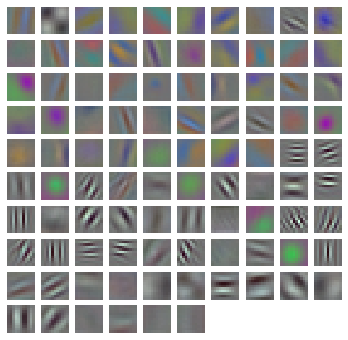

In [7]:
alex_w1 = alex_c12[b"conv1"][0]
print(alex_w1.shape)
mlutils.display_imgs(alex_w1)

### We will use them as starting point for training our network

In [8]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [9]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

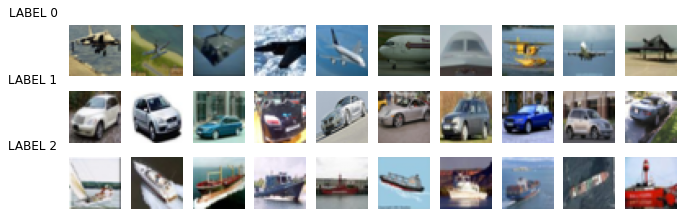

In [10]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
0    769
2    750
1    734
dtype: int64

distribution of test classes
2    275
1    240
0    236
dtype: int64


In [12]:
def get_model(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [13]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [14]:
num_classes = len(np.unique(y_cifar))
model = get_model(num_classes)
model.summary()

using 3 classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)      

## Train from scratch

in some runs might take a while to start reducing loss

In [15]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Epoch 1/15
141/141 [==============================] - 3s 20ms/step - loss: 1.1283 - accuracy: 0.3371 - val_loss: 1.0988 - val_accuracy: 0.3329
Epoch 2/15
141/141 [==============================] - 3s 18ms/step - loss: 1.0934 - accuracy: 0.3666 - val_loss: 1.0427 - val_accuracy: 0.4274
Epoch 3/15
141/141 [==============================] - 3s 18ms/step - loss: 1.0586 - accuracy: 0.4369 - val_loss: 1.0446 - val_accuracy: 0.4314
Epoch 4/15
141/141 [==============================] - 3s 18ms/step - loss: 1.0355 - accuracy: 0.4536 - val_loss: 1.0159 - val_accuracy: 0.4847
Epoch 5/15
141/141 [==============================] - 2s 18ms/step - loss: 1.0295 - accuracy: 0.4641 - val_loss: 1.0007 - val_accuracy: 0.5393
Epoch 6/15
141/141 [==============================] - 3s 18ms/step - loss: 1.0114 - accuracy: 0.5016 - val_loss: 0.9795 - val_accuracy: 0.5499
Epoch 7/15
141/141 [==============================] - 3s 18ms/step - loss: 0.9972 - accuracy: 0.4710 - val_loss: 0.9574 - val_accuracy: 0.5260

{'loss': 0.9248688220977783, 'accuracy': 0.5685752034187317}

Normalized confusion matrix
[[0.48305085 0.20762712 0.30932203]
 [0.05833333 0.67916667 0.2625    ]
 [0.28727273 0.16727273 0.54545455]]


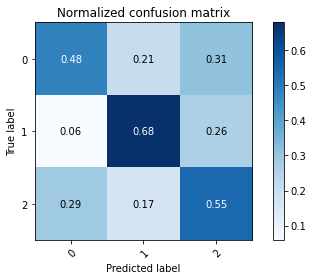

In [16]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

## Transfer learning!!!

- Keep first level filters to compare later


In [17]:
model = get_model(num_classes)
w = model.get_weights()
for i in w:
    print(i.shape)

using 3 classes
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


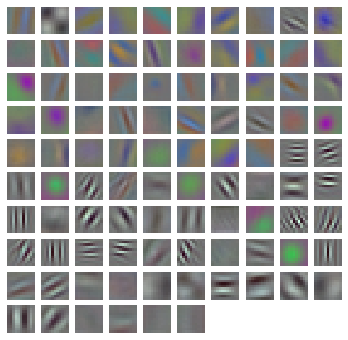

In [18]:
w[0] = alex_w1
model.set_weights(w)
mlutils.display_imgs(model.get_weights()[0])

In [19]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Epoch 1/15
141/141 [==============================] - 3s 20ms/step - loss: 1.1366 - accuracy: 0.3932 - val_loss: 0.9753 - val_accuracy: 0.6458
Epoch 2/15
141/141 [==============================] - 3s 18ms/step - loss: 0.9676 - accuracy: 0.5499 - val_loss: 0.9510 - val_accuracy: 0.5513
Epoch 3/15
141/141 [==============================] - 3s 18ms/step - loss: 0.8886 - accuracy: 0.5938 - val_loss: 0.8310 - val_accuracy: 0.6591
Epoch 4/15
141/141 [==============================] - 3s 18ms/step - loss: 0.8180 - accuracy: 0.6287 - val_loss: 0.7262 - val_accuracy: 0.7084
Epoch 5/15
141/141 [==============================] - 3s 18ms/step - loss: 0.7335 - accuracy: 0.6893 - val_loss: 0.7712 - val_accuracy: 0.6671
Epoch 6/15
141/141 [==============================] - 3s 18ms/step - loss: 0.7056 - accuracy: 0.6992 - val_loss: 0.6892 - val_accuracy: 0.7057
Epoch 7/15
141/141 [==============================] - 3s 18ms/step - loss: 0.6646 - accuracy: 0.7138 - val_loss: 0.6665 - val_accuracy: 0.7217

{'loss': 0.7341428995132446, 'accuracy': 0.7443408966064453}

Normalized confusion matrix
[[0.74152542 0.05084746 0.20762712]
 [0.12916667 0.8        0.07083333]
 [0.21090909 0.09090909 0.69818182]]


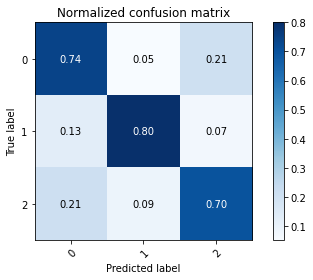

In [20]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

first level filters changed but not much

In [21]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.024149708

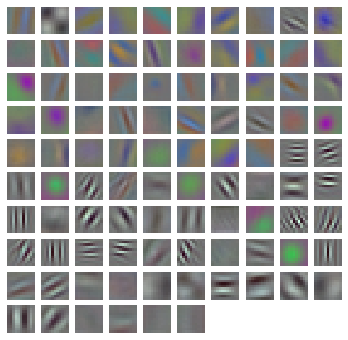

In [22]:
mlutils.display_imgs(w[0])

In [23]:
model.save("alexnet_finetuned_minicifar.model")

INFO:tensorflow:Assets written to: alexnet_finetuned_minicifar.model/assets


observe that you can also save separately the architecture

In [24]:
with open('alexnet_finetuned_minicifar.architecture.json', 'w') as f:
    f.write(model.to_json())

In [25]:
!ls -lash alexnet_finetuned_minicifar*

4,0K -rw-rw-r-- 1 rlx rlx 3,5K Jan 27 21:11 alexnet_finetuned_minicifar.architecture.json

alexnet_finetuned_minicifar.model:
total 168K
4,0K drwxr-xr-x 4 rlx rlx 4,0K Jan 27 21:11 .
4,0K drwxr-xr-x 7 rlx rlx 4,0K Jan 27 21:11 ..
4,0K drwxr-xr-x 2 rlx rlx 4,0K Jan 27 21:11 assets
152K -rw-rw-r-- 1 rlx rlx 152K Jan 27 21:11 saved_model.pb
4,0K drwxr-xr-x 2 rlx rlx 4,0K Jan 27 21:11 variables


In [26]:
!head alexnet_finetuned_minicifar.architecture.json

{"class_name": "Functional", "config": {"name": "model_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d_2", "trainable": true, "dtype": "float32", "filters": 96, "kernel_size": [11, 11], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d_2", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d_1", "trainable": true, "dtype": "float32", "

## Could also freeze weights to avoid being changed by training

In [27]:
def get_modelT(num_classes, img_size=32, compile=True):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu", trainable=False)(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [28]:
model = get_modelT(num_classes)
w = model.get_weights()
w[0] = alex_w1
model.set_weights(w)

using 3 classes


In [29]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Epoch 1/15
141/141 [==============================] - 2s 10ms/step - loss: 1.3444 - accuracy: 0.3657 - val_loss: 0.9156 - val_accuracy: 0.5406
Epoch 2/15
141/141 [==============================] - 1s 10ms/step - loss: 0.9494 - accuracy: 0.5068 - val_loss: 0.8395 - val_accuracy: 0.6059
Epoch 3/15
141/141 [==============================] - 1s 9ms/step - loss: 0.8832 - accuracy: 0.5502 - val_loss: 0.7787 - val_accuracy: 0.7204
Epoch 4/15
141/141 [==============================] - 1s 9ms/step - loss: 0.8231 - accuracy: 0.5990 - val_loss: 0.6660 - val_accuracy: 0.7683
Epoch 5/15
141/141 [==============================] - 1s 9ms/step - loss: 0.7679 - accuracy: 0.6256 - val_loss: 0.6897 - val_accuracy: 0.7483
Epoch 6/15
141/141 [==============================] - 1s 9ms/step - loss: 0.7963 - accuracy: 0.6048 - val_loss: 0.5991 - val_accuracy: 0.7656
Epoch 7/15
141/141 [==============================] - 1s 10ms/step - loss: 0.7414 - accuracy: 0.6711 - val_loss: 0.6323 - val_accuracy: 0.7510
Epo

{'loss': 0.5832616686820984, 'accuracy': 0.7922769784927368}

Normalized confusion matrix
[[0.75       0.05932203 0.19067797]
 [0.06666667 0.81666667 0.11666667]
 [0.13454545 0.05818182 0.80727273]]


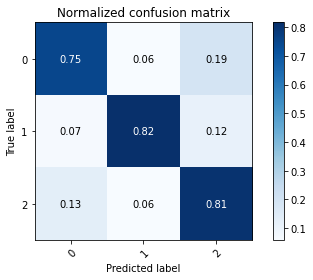

In [30]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

check filters did not change

In [31]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.0